# Computing NLO Phase Shifts in Coordinate Space

We have seen that computing NLO phase shifts at large Lambda = 2/R values is numerically difficult – presumably because of the Fourier transform. We will try and bypass those issues by doing the calculation entirely in coordinate space.

The $t$-matrix amplitude is approximated as
$$
t = t^{(0)} + t^{(1)}
$$
We're going to consider the Born approximation for $t^{(1)}$,
$$
t^{(1)} \approx -\frac{2\mu}{k} \langle \phi^{(0)} | V_{\rm NLO} | \phi^{(0)} \rangle
$$

(Is this the DWBA?)

We need $\phi^{(0)}$, and we need it properly/consistently **normalized**. Then we need to compute the integral. Finally, we'll (carefully) extract the phase shift via
$$
e^{2i\delta} = S = 1 - 2it
$$

Steps:

1. Compute $\phi^{(0)}$.
2. Compute $\delta^{(0)}$ (compare to previous results).
3. Normalize $\phi^{(0)}$. (???)
4. Compute $t^{(0)} = e^{i\delta^{(0)}}\sin\delta^{(0)}$
5. Compute the matrix element (integral), $\langle \phi^{(0)} | V_{\rm NLO} | \phi^{(0)} \rangle$.
6. Compute $t=t^{(0)} + t^{(1)}$ and extract the NLO $\delta$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad
from scipy.interpolate import interp1d
from scipy import optimize
from tqdm import tqdm
from multiprocess import Pool

from finite_differences import second_order_deriv
from interaction import regulator
from counterterm import local_LO_counterterm
from constants import MU, BETA4, C4
from utility import log_mesh
from free_solutions import phi_free, H_minus, H_minus_prime, H_plus, H_plus_prime

plt.style.use('science')
ratio = 4/3
h = 3

Read in RG flows (LO and NLO) and LO results.

In [2]:
rgf = np.loadtxt('rgflow_local_lo_a0_fix_hp_n_14_coord_ir_corrected.txt')
rgf_nlo = np.loadtxt('rgflow_local_nlo_a0_B6_fix_coord_hp_n_14_coord_ir_corrected.txt')

deltas_lo = np.loadtxt('phase_shifts_lo_wide_dense_hp_n_14_coord_ir_corrected.txt')
ks_lo = deltas_lo[:, 0]
deltas_lo = deltas_lo[:, 1:].T

At what energies/momenta are we going to compute the phase shifts?

In [3]:
ks = np.hstack(
    (np.logspace(np.log10(0.1/BETA4), np.log10(10/BETA4), 50),
     np.linspace(10.1/BETA4, 100/BETA4, 50))
)
energies = ks**2/(2*MU)

In [4]:
def phase_shift(u, up, ell, x0):
    rl = 1/x0 * (u/up)
    return np.log(
        (H_minus(x0, ell) - x0*rl*H_minus_prime(x0, ell)) / 
        (H_plus(x0, ell) - x0*rl*H_plus_prime(x0, ell))
    ) / 2j


def phase_shift_interp(u, s, ell, x0, dx=1e-6):
    '''
    Given the solution, u, on the s grid, return the phase shift (with respect to the free solution).
    '''
    u_func = interp1d(s, u, kind='cubic')
    rl = 1/x0 * (u_func(x0)/derivative(u_func, x0, dx=dx))
    return np.log(
        (H_minus(x0, ell) - x0*rl*H_minus_prime(x0, ell)) / 
        (H_plus(x0, ell) - x0*rl*H_plus_prime(x0, ell))
    ) / 2j

In [15]:
def wave_function(v_r, energy, r_endpts=np.array([0, 10000])):
#     k0 = np.sqrt(2*MU* np.abs(v_r(0) - energy))
    k = np.sqrt(2*MU*energy)
    sol = solve_ivp(
        lambda r, phi: np.array([phi[1], 2*MU*(v_r(r) - energy) * phi[0]], dtype=object),
        r_endpts, [0, 1], rtol=1e-9, atol=1e-12,
        dense_output=True, method='DOP853'
    )
    return sol.sol

def wave_function_rho(v_r, energy, rho_endpts=np.array([0, 8*np.pi])):
    k = np.sqrt(2*MU*energy)
    v_tilde = lambda rho: v_r(rho/k)/energy
    sol = solve_ivp(
        lambda rho, phi: [phi[1], (v_tilde(rho) - 1) * phi[0]], rho_endpts, [0, 1], rtol=1e-9, atol=1e-12,
        dense_output=True, method='DOP853'
    )
    return sol.sol


def construct_potential(R, c0, c2):
    def v4(r):
        if r == 0:
            return 0
        else:
            return -C4/r**4

    return lambda r: regulator(r, R)*v4(r) + c0*local_LO_counterterm(r, R)


def solutions(pot):
    return [wave_function(pot, en) for en in tqdm(energies)]


def delta_interp(sol, k, r_match=50, max_rel_diff=1e-6, factor=1.01, dx=1e-6):
    delta_0 = np.random.rand()
    rel_diff = 1
    
    while rel_diff > max_rel_diff:
        r = np.linspace(0.99*r_match, 1.01*r_match, 100)
        rho = k*r
#         u, up = sol(r_match)
#         delta_1 = phase_shift(u, up, 0, k*r_match).real
        u = sol(r)[0]
        delta_1 = phase_shift_interp(u, rho, 0, k*r_match, dx=dx).real
        
        rel_diff = np.abs((delta_1 - delta_0)/delta_0)
        delta_0 = delta_1
        r_match *= factor
    
    return delta_1


def delta_interp_rho(sol, k, rho_match=4*np.pi, max_rel_diff=1e-6, factor=1.01, dx=1e-6):
    delta_0 = np.random.rand()
    rel_diff = 1
    
    while rel_diff > max_rel_diff:
        rho = np.linspace(0.99*rho_match, 1.01*rho_match, 100)
        u, _ = sol(rho)
        delta_1 = phase_shift_interp(u, rho, 0, rho_match, dx=dx).real
        rel_diff = np.abs((delta_1 - delta_0)/delta_0)
        delta_0 = delta_1
        rho_match *= factor
    
    return delta_1


def norm_factors(u, k, delta0):
    rho_max_amp = np.pi/2 + 6*np.pi - delta0
    return np.abs(u(rho_max_amp)[0]) # / (np.sqrt(2/np.pi))


def integrand(phi0, energy):
    k = np.sqrt(2*MU*energy)
    v1 = c2 * energy * local_LO_counterterm(r_int, R)
    return interp1d(r_int, phi0 * v1 * phi0, kind='cubic')


def matrix_element(phi0, energy):
    k = np.sqrt(2*MU*energy)
    result = quad(integrand(phi0, energy), 1e-4, 2*R)
    return -2*MU/k * result[0]

In [6]:
R, c0, c2 = rgf_nlo[0]
pot = construct_potential(R, c0, c2)
f = lambda en: phi(pot, en)

ii = 99

In [7]:
sol1 = wave_function(pot, energies[ii])
sol2 = wave_function_rho(pot, energies[ii])

In [16]:
phi0_solutions = solutions(pot)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:19<00:00,  1.99s/it]


In [17]:
delta0s = [delta_interp(sol, k) for (sol, k) in tqdm(zip(phi0_solutions, ks))]

0it [00:00, ?it/s]/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_34765/544316099.py:14: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  rl = 1/x0 * (u_func(x0)/derivative(u_func, x0, dx=dx))
89it [00:02, 33.10it/s]/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_34765/544316099.py:14: RuntimeWarning: divide by zero encountered in true_divide
  rl = 1/x0 * (u_func(x0)/derivative(u_func, x0, dx=dx))
/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_34765/544316099.py:16: RuntimeWarning: invalid value encountered in multiply
  (H_minus(x0, ell) - x0*rl*H_minus_prime(x0, ell)) /
/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_34765/544316099.py:17: RuntimeWarning: invalid value encountered in multiply
  (H_plus(x0, ell) - x0*rl*H_plus_prime(x0, ell))
100

In [18]:
phi0_solutions_rho = [wave_function_rho(pot, en) for en in tqdm(energies)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 62.37it/s]


In [23]:
np.where(np.isnan(delta0s_rho))

(array([49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),)

In [28]:
delta_interp_rho(phi0_solutions_rho[49], ks[ii], rho_match=2*np.pi, factor=1.001)

/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_34765/544316099.py:14: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  rl = 1/x0 * (u_func(x0)/derivative(u_func, x0, dx=dx))


0.32314829608542117

In [35]:
delta0s_rho = [delta_interp_rho(sol, k, rho_match=4*np.pi, factor=1.005) for (sol, k) in tqdm(zip(phi0_solutions_rho, ks))]


0it [00:00, ?it/s]/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_34765/544316099.py:14: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  rl = 1/x0 * (u_func(x0)/derivative(u_func, x0, dx=dx))

43it [00:00, 427.67it/s]/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_34765/544316099.py:14: RuntimeWarning: divide by zero encountered in true_divide
  rl = 1/x0 * (u_func(x0)/derivative(u_func, x0, dx=dx))
/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_34765/544316099.py:16: RuntimeWarning: invalid value encountered in multiply
  (H_minus(x0, ell) - x0*rl*H_minus_prime(x0, ell)) /
/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_34765/544316099.py:17: RuntimeWarning: invalid value encountered in multiply
  (H_plus(x0, ell) - x0*rl*H_plus_prime(x0, ell))


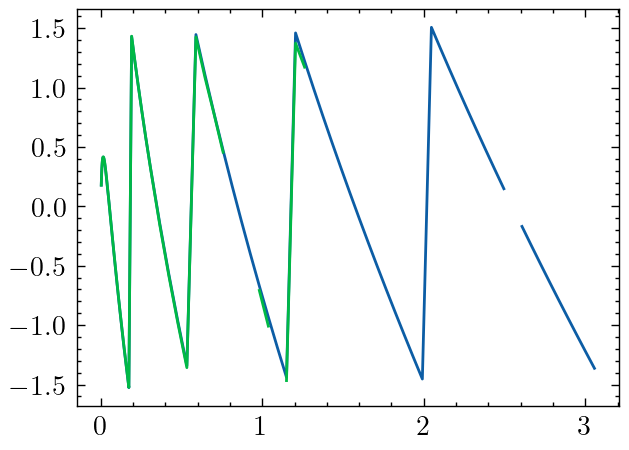

In [37]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(ks, delta0s)
ax.plot(ks, delta0s_rho);

In [38]:
deltas = []

for (R, c0, c2) in tqdm(rgf_nlo):
    pot = construct_potential(R, c0, c2)
    f = lambda en: wave_function(pot, en)
    
    with Pool(4) as pool:
        phi0_solutions = pool.map(f, energies)
    
    delta0s = np.array([delta_interp(sol, k) for (sol, k) in zip(phi0_solutions, ks)])
    nfs = np.array([norm_factors(sol, k, d0) for (sol, k, d0) in zip(phi0_solutions, ks, delta0s)])
    
    r_int, _ = log_mesh(0, 2*R, 4000)
    phi0_int = [u(r_int)[0] / nf for (u, nf, k) in zip(phi0_solutions, nfs, ks)]

    t0s = np.exp(1j*delta0s) * np.sin(delta0s)
        
    integrands = [integrand(phi0, en) for (phi0, en) in zip(phi0_int, energies)]
    mes = np.array([matrix_element(phi0, en) for (phi0, en) in zip(phi0_int, energies)])
    mes_1 = np.array([me * np.exp(2j*d) for (me, d) in zip(mes, delta0s)])

    delta1s = mes_1 * np.exp(-2j * delta0s)
    deltas.append(delta0s + delta1s)
    
#     ts = t0s + mes_1
#     deltas.append(np.arctan(ts / (1 + 1j*ts)))


  0%|                                                                                                                                               | 0/79 [00:00<?, ?it/s]/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_34765/544316099.py:14: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  rl = 1/x0 * (u_func(x0)/derivative(u_func, x0, dx=dx))
/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_34765/544316099.py:14: RuntimeWarning: divide by zero encountered in true_divide
  rl = 1/x0 * (u_func(x0)/derivative(u_func, x0, dx=dx))
/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_34765/544316099.py:16: RuntimeWarning: invalid value encountered in multiply
  (H_minus(x0, ell) - x0*rl*H_minus_prime(x0, ell)) /
/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel

KeyboardInterrupt: 

In [13]:
np.array(deltas).shape

(79, 100)

In [7]:
np.any(np.isnan(deltas))

True

In [16]:
jj = np.where(np.isnan(deltas))[1]
jj.shape

(4029,)

In [9]:
good_ks = np.delete(ks, jj)
good_deltas = np.delete(deltas, jj, axis=1)

In [10]:
deltas_mm = np.loadtxt('phase_shifts_mott_massey_wide_dense_coord_ir_corrected.txt')
ks_mm = deltas_mm[:, 0]
deltas_mm = deltas_mm[:, 1]

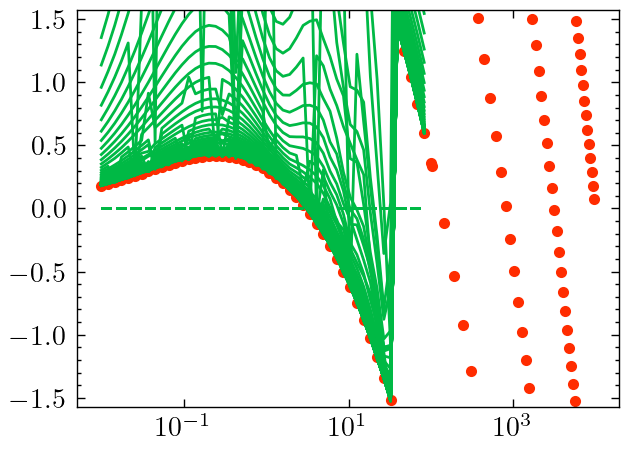

In [11]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')


for d in good_deltas:
    ax.plot((good_ks*BETA4)**2, d.real, color='C1')
    ax.plot((good_ks*BETA4)**2, d.imag, color='C1', linestyle='--')

ax.scatter((ks_mm*BETA4)**2, deltas_mm, color='C3', marker='.')

ax.set_ylim([-np.pi/2, np.pi/2])
# ax.set_xlim([0.1, 30])
ax.set_xscale('log');

In [17]:
np.savetxt('phase_shifts_pert_nlo_pert1_wide_dense_hp_n_14_true_coord_ir_corrected.txt',
           np.vstack((good_ks, good_deltas)).T)

In [19]:
good_ks.shape, good_deltas.shape

((98,), (79, 98))

In [40]:
Delta = 5*np.pi

def find_minus_to_plus(x):
    n = x.size
    indices = []
    for i in range(n-1):
        if np.sign(x[i]) == -1 and  np.sign(x[i+1]) == 1:
            indices.append(i+1)
    return indices

def shift(x, add_pi=False):
    xp = x.copy()
    indices = find_minus_to_plus(xp)
    i = 0
    s = 0
    for j in indices:
#         print(i, j, s)
        xp[i:j] -= s*np.pi
        s += 1
        i = j
    xp[j:] -= s*np.pi
    return xp + (Delta if add_pi else 0)

In [43]:
mm = shift(deltas_mm, True)
lo = shift(delta0s, True)
nlo = shift(deltas, True)

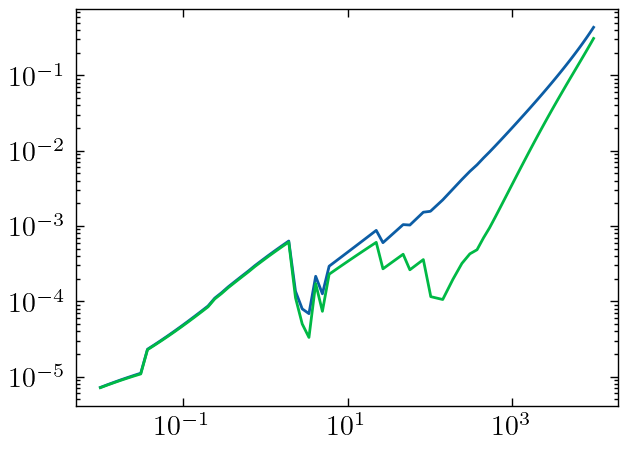

In [51]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot((ks*BETA4)**2, np.abs((lo/mm) - 1))
ax.plot((ks*BETA4)**2, np.abs((nlo/mm) - 1))

ax.set_xscale('log')
ax.set_yscale('log');

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(10, 10000)

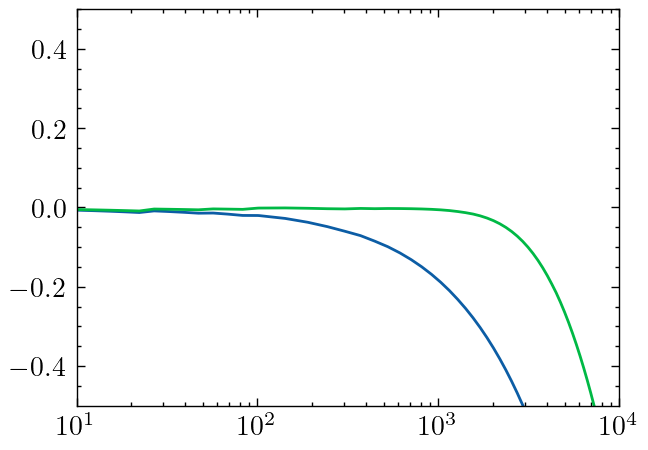

In [55]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot((ks*BETA4)**2, lo - mm)
ax.plot((ks*BETA4)**2, nlo - mm)

ax.set_xscale('log')
ax.set_ylim([-0.5, 0.5])
ax.set_xlim([10, 10000])
# ax.set_yscale('log');